# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: Predicting wine quality
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
# import the data
data = pd.read_csv('../seaborn-data-master/winequality-red.csv',sep=';')
data = data[data['total sulfur dioxide']<200]

# find the columns we want to normalize (all except quality)
# z-score (written out for clarity)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_20804/1574832436.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


# Re-organize the data: train/test in DataLoaders

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = int(train_data.tensors[0].shape[0]/5)
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([287, 11]) torch.Size([287, 1])
torch.Size([287, 11]) torch.Size([287, 1])
torch.Size([287, 11]) torch.Size([287, 1])
torch.Size([287, 11]) torch.Size([287, 1])
torch.Size([287, 11]) torch.Size([287, 1])


# Now for the DL part

In [6]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # define dropout
    self.dropout = nn.Dropout(.25)
  

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = self.dropout(x)
    x = F.relu( self.fc2(x) )
    x = self.dropout(x)
    return self.output(x)

In [7]:
# generate an instance of the model and inspect it
net = ANNwine()
net

ANNwine(
  (input): Linear(in_features=11, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [8]:
# A quick test of running some numbers through the model. 
# This simply ensures that the architecture is internally consistent.

# 10 samples, 11 dimensions
tmpx = torch.randn(10,11)

# run it through the DL
y = net(tmpx)

# exam the shape of the output
print( y.shape ), print(' ')

# and the output itself
print(y)

torch.Size([10, 1])
 
tensor([[-0.2945],
        [-0.2378],
        [-0.2046],
        [-0.2733],
        [-0.1763],
        [-0.2112],
        [-0.1777],
        [-0.1739],
        [-0.1973],
        [-0.1974]], grad_fn=<AddmmBackward0>)


In [9]:
# another sanity-check: run a batch of data through

littleData = next(iter(train_loader))
y = net(littleData[0])
y

tensor([[-0.2939],
        [-0.1543],
        [-0.1524],
        [-0.3198],
        [-0.1983],
        [-0.2380],
        [-0.1634],
        [-0.1666],
        [-0.2246],
        [-0.2474],
        [-0.3085],
        [-0.1953],
        [-0.4630],
        [-0.1112],
        [-0.1078],
        [-0.1599],
        [-0.1595],
        [-0.2289],
        [-0.2569],
        [-0.1496],
        [-0.2552],
        [-0.3008],
        [-0.2392],
        [-0.2269],
        [-0.2742],
        [-0.2131],
        [-0.2309],
        [-0.1995],
        [-0.1372],
        [-0.2002],
        [-0.1262],
        [-0.1765],
        [-0.2139],
        [-0.1834],
        [-0.1095],
        [-0.2200],
        [-0.2937],
        [-0.2148],
        [-0.2861],
        [-0.2389],
        [-0.1932],
        [-0.1458],
        [-0.1827],
        [-0.1881],
        [-0.1501],
        [-0.3031],
        [-0.1786],
        [-0.1818],
        [-0.1767],
        [-0.2432],
        [-0.1562],
        [-0.3657],
        [-0.

# Train the model

In [10]:
# a function that trains the model

# global parameter
numepochs = 3000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [11]:
# create a new model instance
winenet = ANNwine()

# train the model
trainAcc,testAcc,losses = trainTheModel()


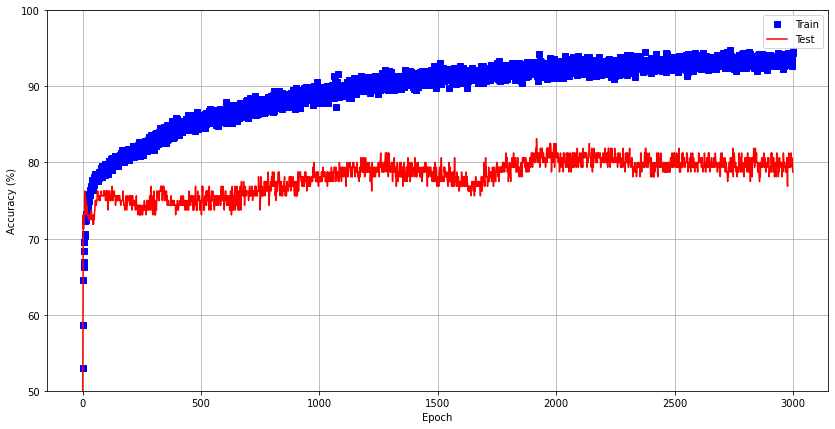

In [12]:
# plot some results
fig = plt.figure(figsize=(14,7))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'r')
plt.legend(['Train','Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim([50,100])
plt.grid()
plt.show()